<span style="color:darkcyan;">**Téléchargement des bibliothèques**</span>

In [1]:
import pandas as pd
!pip install openpyxl


<span style="color:darkcyan;">**Importation de la base de données et création du data frame**</span>

In [2]:
df = pd.read_excel('/home/onyxia/work/Projet_Python-pour-la-data-science/données_vols.xlsx')
# Afficher les 5 premières lignes pour vérifier
print(df.head(5))

  Carrier Code    Date (MM/DD/YYYY)  Flight Number Tail Number  \
0           AA  2020-01-01 00:00:00              1      N110AN   
1           AA  2020-01-01 00:00:00              3      N111ZM   
2           AA  2020-01-01 00:00:00            111      N663AW   
3           AA  2020-01-01 00:00:00            117      N113AN   
4           AA  2020-01-01 00:00:00            179      N103NN   

  Destination Airport Scheduled departure time Actual departure time  \
0                 LAX                 07:30:00              07:30:00   
1                 LAX                 12:30:00              12:24:00   
2                 CLT                 12:00:00              13:11:00   
3                 LAX                 19:30:00              19:26:00   
4                 SFO                 10:30:00              10:25:00   

   Scheduled elapsed time (Minutes)  Actual elapsed time (Minutes)  \
0                               393                            404   
1                             

In [3]:
# Vérifier si le DataFrame contient des valeurs manquantes
print(df.isnull().values.any())

True


In [4]:
# Nombre de valeurs manquantes par colonne
print(df.isnull().sum())

Carrier Code                                  0
Date (MM/DD/YYYY)                             0
Flight Number                                 0
Tail Number                                 226
Destination Airport                           0
Scheduled departure time                      0
Actual departure time                         0
Scheduled elapsed time (Minutes)              0
Actual elapsed time (Minutes)                 0
Departure delay (Minutes)                     0
Wheels-off time                               0
Taxi-Out time (Minutes)                       0
Delay Carrier (Minutes)                       0
Delay Weather (Minutes)                       0
Delay National Aviation System (Minutes)      0
Delay Security (Minutes)                      0
Delay Late Aircraft Arrival (Minutes)         0
dtype: int64


<span style="color:lightpink;">**Commentaire de la sortie**</span>

<small>La seule variable qui présente des valeurs manquantes est **Tail Number**. Cependant il ne s'agit pas d'une variable explicative dans notre modèle, ainsi ces valeurs manquantes ne nécessite aucun traitement.</small>

In [5]:
# Filtrer les lignes avec des valeurs manquantes
missing_values_rows = df[df.isnull().any(axis=1)]

# Afficher les lignes avec des valeurs manquantes
print(missing_values_rows)

      Carrier Code    Date (MM/DD/YYYY)  Flight Number Tail Number  \
13937           AA           03/18/2020            796         NaN   
14121           AA           03/19/2020            796         NaN   
14304           AA           03/20/2020            796         NaN   
14492           AA           03/21/2020            796         NaN   
15035           AA           03/24/2020            177         NaN   
...            ...                  ...            ...         ...   
35523           AA           07/28/2020            243         NaN   
35524           AA           07/28/2020            250         NaN   
35694           AA           07/29/2020            250         NaN   
35706           AA           07/29/2020           2452         NaN   
49330           AA  2021-01-11 00:00:00            595         NaN   

      Destination Airport Scheduled departure time Actual departure time  \
13937                 EGE                 10:59:00              00:00:00   
14121  

<span style="color:darkcyan;">**Extraction de la date du jour du vol de la colonne Date (MM/DD/YYYY)**</span>

<small>D'après la sortie du code précédent, nous pouvons clairement voir que la colonne **Date (MM/DD/YYYY)** ne contient pas uniquement la date du jour du vol mais aussi la chaîne de caractère **00:00:00** qui renvoie à **l'heure du début d'un jour**.</small>

In [6]:
# Extraire uniquement la date de la colonne Date (MM/DD/YYYY) dans la nouvelle colonne Date
df['Date'] = pd.to_datetime(df['Date (MM/DD/YYYY)'], format='%m/%d/%Y').dt.date

# Afficher la colonne Date
print(df.Date)

0        2020-01-01
1        2020-01-01
2        2020-01-01
3        2020-01-01
4        2020-01-01
            ...    
57405    2023-12-31
57406    2023-12-31
57407    2023-12-31
57408    2023-12-31
57409    2023-12-31
Name: Date, Length: 57410, dtype: object


<span style="color:darkcyan;">**Création de la colonne Weekday_Flight**</span>

<small>Nous aimerions aussi voir si **le retard d'un vol peut être lié au jour de la semaine où le vol aura lieu**. Pour cela, il est nécessaire de créer une colonne contenant le jour de la semaine **(Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday)** correspondant à chaque vol de notre data frame.
</small>

In [7]:
# Convertir la colonne 'Date' en format datetime 
df['Date'] = pd.to_datetime(df['Date'])

# Créer la colonne Weekday_Flight avec les jours de la semaine correspondant aux dates des vols
df['Weekday_Flight'] = df['Date'].dt.day_name()

# Afficher Date et Weekday_Flight
print(df[['Date','Weekday_Flight']])

            Date Weekday_Flight
0     2020-01-01      Wednesday
1     2020-01-01      Wednesday
2     2020-01-01      Wednesday
3     2020-01-01      Wednesday
4     2020-01-01      Wednesday
...          ...            ...
57405 2023-12-31         Sunday
57406 2023-12-31         Sunday
57407 2023-12-31         Sunday
57408 2023-12-31         Sunday
57409 2023-12-31         Sunday

[57410 rows x 2 columns]


<span style="color:darkcyan;">**Création de la colonne Season**</span>

<small> La variable **"saison"** peut influencer les retards des vols en raison des **variations météorologiques** et des **volumes de trafic** spécifiques à chaque période de l'année. Par exemple, l’hiver apporte souvent des conditions difficiles comme la neige ou le brouillard, tandis que l’été, marqué par un trafic élevé, peut être perturbé par des orages ou des surcharges aéroportuaires. Ainsi, en tenant compte des saisons, il devient possible de mieux comprendre et anticiper les facteurs contribuant aux retards. </small>

In [8]:
# Définir une fonction qui détermine pour une date données la saison correspondante
def get_season(date):
    year = date.year
    if date >= pd.Timestamp(year=year, month=3, day=21) and date < pd.Timestamp(year=year, month=6, day=21):
        return 'Printemps'
    elif date >= pd.Timestamp(year=year, month=6, day=21) and date < pd.Timestamp(year=year, month=9, day=23):
        return 'Été'
    elif date >= pd.Timestamp(year=year, month=9, day=23) and date < pd.Timestamp(year=year, month=12, day=21):
        return 'Automne'
    else:
        return 'Hiver'


# Convertir la colonne Date en datetime 
df['Date'] = pd.to_datetime(df['Date'])

# Appliquer la fonction sur la colonne Date du dataframe
df['Season'] = df['Date'].apply(get_season)

# Afficher  des observations aléatoires du DataFrame
print(df.Season[1000:1010])
print(df.Season[2000:2010])


1000    Printemps
1001    Printemps
1002    Printemps
1003    Printemps
1004    Printemps
1005    Printemps
1006    Printemps
1007    Printemps
1008    Printemps
1009    Printemps
Name: Season, dtype: object
2000    Automne
2001    Automne
2002    Automne
2003    Automne
2004    Automne
2005    Automne
2006    Automne
2007    Automne
2008    Automne
2009    Automne
Name: Season, dtype: object


<span style="color:darkcyan;">**Création de la colonne Period_Day**</span>

In [9]:
# Définir une fonction pour attribuer la période de la journée
def definir_periode(heure):
    if heure >= pd.to_datetime('06:00', format='%H:%M').time() and heure < pd.to_datetime('12:00', format='%H:%M').time():
        return 'Matin'
    elif heure >= pd.to_datetime('12:00', format='%H:%M').time() and heure < pd.to_datetime('18:00', format='%H:%M').time():
        return 'Après-midi'
    else:
        return 'Soir'

# Convertir la colonne en type datetime
df['Scheduled departure time'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M:%S')

# Appliquer la fonction pour créer une nouvelle colonne
df['Period_Day'] = df['Scheduled departure time'].dt.time.apply(definir_periode)

# Reconvertir les colonnes "Scheduled departure time" et "Actual departure time" pour ne garder que l'heure 
df['Scheduled departure time'] = df['Scheduled departure time'].dt.time

# Afficher les colonnes Period_Day et Scheduled departure time
print(df[['Scheduled departure time','Period_Day']])

      Scheduled departure time  Period_Day
0                     07:30:00       Matin
1                     12:30:00  Après-midi
2                     12:00:00  Après-midi
3                     19:30:00        Soir
4                     10:30:00       Matin
...                        ...         ...
57405                 17:29:00  Après-midi
57406                 12:30:00  Après-midi
57407                 06:59:00       Matin
57408                 08:59:00       Matin
57409                 12:59:00  Après-midi

[57410 rows x 2 columns]


<span style="color:darkcyan;">**Création de notre variable cible Y=Delay**</span>

<small> Le **retard d'un vol au départ** se définit comme **l'écart entre l'heure de départ ou d'arrivée prévue d'un vol, telle qu'indiquée dans le programme, et l'heure réelle à laquelle le vol décolle**.. Un vol est souvent considéré en retard si cet écart dépasse un seuil défini, par exemple 5 minutes.
</small>

In [10]:
# Convertir les colonnes "Scheduled departure time" et "Actual departure time" en objets datetime
df['Scheduled departure time'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M:%S')
df['Actual departure time'] = pd.to_datetime(df['Actual departure time'], format='%H:%M:%S')

# Création de la variable cible "Retard en calculant la différence en minutes et appliquer la condition
df['Retard'] = ((df['Actual departure time'] - df['Scheduled departure time']).dt.total_seconds() / 60 > 0).astype(int)

# Afficher les colonnes "Actual departure time", "Scheduled departure time" et "Retard"
print(df[['Actual departure time', 'Scheduled departure time', 'Retard']])


      Actual departure time Scheduled departure time  Retard
0       1900-01-01 07:30:00      1900-01-01 07:30:00       0
1       1900-01-01 12:24:00      1900-01-01 12:30:00       0
2       1900-01-01 13:11:00      1900-01-01 12:00:00       1
3       1900-01-01 19:26:00      1900-01-01 19:30:00       0
4       1900-01-01 10:25:00      1900-01-01 10:30:00       0
...                     ...                      ...     ...
57405   1900-01-01 17:25:00      1900-01-01 17:29:00       0
57406   1900-01-01 12:26:00      1900-01-01 12:30:00       0
57407   1900-01-01 06:57:00      1900-01-01 06:59:00       0
57408   1900-01-01 08:53:00      1900-01-01 08:59:00       0
57409   1900-01-01 12:57:00      1900-01-01 12:59:00       0

[57410 rows x 3 columns]


In [11]:

# Reconvertir les colonnes "Scheduled departure time" et "Actual departure time" pour ne garder que l'heure 
df['Scheduled departure time'] = df['Scheduled departure time'].dt.time
df['Actual departure time'] = df['Actual departure time'].dt.time

# Afficher les colonnes "Actual departure time", "Scheduled departure time" et "Retard"
print(df[['Actual departure time', 'Scheduled departure time', 'Retard']])



      Actual departure time Scheduled departure time  Retard
0                  07:30:00                 07:30:00       0
1                  12:24:00                 12:30:00       0
2                  13:11:00                 12:00:00       1
3                  19:26:00                 19:30:00       0
4                  10:25:00                 10:30:00       0
...                     ...                      ...     ...
57405              17:25:00                 17:29:00       0
57406              12:26:00                 12:30:00       0
57407              06:57:00                 06:59:00       0
57408              08:53:00                 08:59:00       0
57409              12:57:00                 12:59:00       0

[57410 rows x 3 columns]


<span style="color:darkcyan;">**Encodage des variables qualitatives**</span>

In [12]:
!pip install scikit-learn
import sklearn
from sklearn.preprocessing import LabelEncoder

<span style="color:lightpink;">**Encodage de la variable Weekday_Flight**</span>

In [13]:
# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Encoder de la variable Weekday_Flight
df['Weekday_Flight_encoded'] = label_encoder.fit_transform(df['Weekday_Flight'])

# Récupérer les modalités de Weekday_Flight et leurs codes correspondant dans la variable Weekday_Flight_encoded
modalites_et_codes = list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Afficher les modalités et leurs codes
print("Modalités et leurs codes :", modalites_et_codes)

#Afficher les colonnes Weekday_Flight et Weekday_Flight_encoded
print(df[['Weekday_Flight','Weekday_Flight_encoded']])

Modalités et leurs codes : [('Friday', 0), ('Monday', 1), ('Saturday', 2), ('Sunday', 3), ('Thursday', 4), ('Tuesday', 5), ('Wednesday', 6)]
      Weekday_Flight  Weekday_Flight_encoded
0          Wednesday                       6
1          Wednesday                       6
2          Wednesday                       6
3          Wednesday                       6
4          Wednesday                       6
...              ...                     ...
57405         Sunday                       3
57406         Sunday                       3
57407         Sunday                       3
57408         Sunday                       3
57409         Sunday                       3

[57410 rows x 2 columns]


<span style="color:lightpink;">**Encodage de la variable Season**</span>

In [14]:
# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Encoder de la variable Season
df['Season_encoded'] = label_encoder.fit_transform(df['Season'])

# Récupérer les modalités de Season et leurs codes correspondant dans la variable Season_encoded
modalites_et_codes = list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Afficher les modalités et leurs codes
print("Modalités et leurs codes :", modalites_et_codes)

#Afficher des valeurs aléatoires de Season et Season_encoded
print(df[['Season', 'Season_encoded']][1000:1005])
print(df[['Season', 'Season_encoded']][2000:2005])
print(df[['Season', 'Season_encoded']][3000:3005])


Modalités et leurs codes : [('Automne', 0), ('Hiver', 1), ('Printemps', 2), ('Été', 3)]
         Season  Season_encoded
1000  Printemps               2
1001  Printemps               2
1002  Printemps               2
1003  Printemps               2
1004  Printemps               2
       Season  Season_encoded
2000  Automne               0
2001  Automne               0
2002  Automne               0
2003  Automne               0
2004  Automne               0
     Season  Season_encoded
3000  Hiver               1
3001  Hiver               1
3002  Hiver               1
3003  Hiver               1
3004  Hiver               1


<span style="color:lightpink;">**Encodage de la variable Period_Day**</span>

In [15]:
# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Encoder de la variable Period_Day
df['Period_Day_encoded'] = label_encoder.fit_transform(df['Period_Day'])

# Récupérer les modalités de Period_Day et leurs codes correspondant dans la variable Period_Day_encoded
modalites_et_codes = list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Afficher les modalités et leurs codes
print("Modalités et leurs codes :", modalites_et_codes)

#Afficher les colonnes Period_Day et Period_Day_encoded
print(df[['Period_Day','Period_Day_encoded']])

Modalités et leurs codes : [('Après-midi', 0), ('Matin', 1), ('Soir', 2)]
       Period_Day  Period_Day_encoded
0           Matin                   1
1      Après-midi                   0
2      Après-midi                   0
3            Soir                   2
4           Matin                   1
...           ...                 ...
57405  Après-midi                   0
57406  Après-midi                   0
57407       Matin                   1
57408       Matin                   1
57409  Après-midi                   0

[57410 rows x 2 columns]


<span style="color:lightpink;">**Encodage de la variable Destination Airport**</span>

In [16]:
# Initialiser l'encodeur
label_encoder = LabelEncoder()

# Encoder de la variable Destination Airport
df['Destination_encoded'] = label_encoder.fit_transform(df['Destination Airport'])

# Récupérer les modalités de Destination Airport et leurs codes correspondant dans la variable Destination_encoded
modalites_et_codes1 = list(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Afficher les modalités et leurs codes
print("Modalités et leurs codes :", modalites_et_codes1)

#Afficher les colonnes Destination Airport et Destination_encoded
print(df[['Destination Airport','Destination_encoded']])

Modalités et leurs codes : [('AUS', 0), ('BOS', 1), ('CLT', 2), ('DCA', 3), ('DFW', 4), ('EGE', 5), ('FLL', 6), ('JAC', 7), ('LAS', 8), ('LAX', 9), ('MIA', 10), ('ORD', 11), ('PHX', 12), ('RDU', 13), ('SAN', 14), ('SAT', 15), ('SFO', 16), ('SNA', 17), ('STT', 18)]
      Destination Airport  Destination_encoded
0                     LAX                    9
1                     LAX                    9
2                     CLT                    2
3                     LAX                    9
4                     SFO                   16
...                   ...                  ...
57405                 AUS                    0
57406                 MIA                   10
57407                 AUS                    0
57408                 ORD                   11
57409                 PHX                   12

[57410 rows x 2 columns]


<span style="color:darkcyan;">**Suppression des variables non porteurs de sens à notre problématique**</span>

In [17]:
df = df.drop(columns=["Date (MM/DD/YYYY)", "Carrier Code","Flight Number","Tail Number","Scheduled elapsed time (Minutes)","Actual elapsed time (Minutes)"])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57410 entries, 0 to 57409
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Destination Airport                       57410 non-null  object        
 1   Scheduled departure time                  57410 non-null  object        
 2   Actual departure time                     57410 non-null  object        
 3   Departure delay (Minutes)                 57410 non-null  int64         
 4   Wheels-off time                           57410 non-null  object        
 5   Taxi-Out time (Minutes)                   57410 non-null  int64         
 6   Delay Carrier (Minutes)                   57410 non-null  int64         
 7   Delay Weather (Minutes)                   57410 non-null  int64         
 8   Delay National Aviation System (Minutes)  57410 non-null  int64         
 9   Delay Security (Minutes)    

In [21]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt  # Pour les graphiques
import seaborn as sns  # Pour les graphiques statistiques
import pandas as pd  # Pour manipuler les données

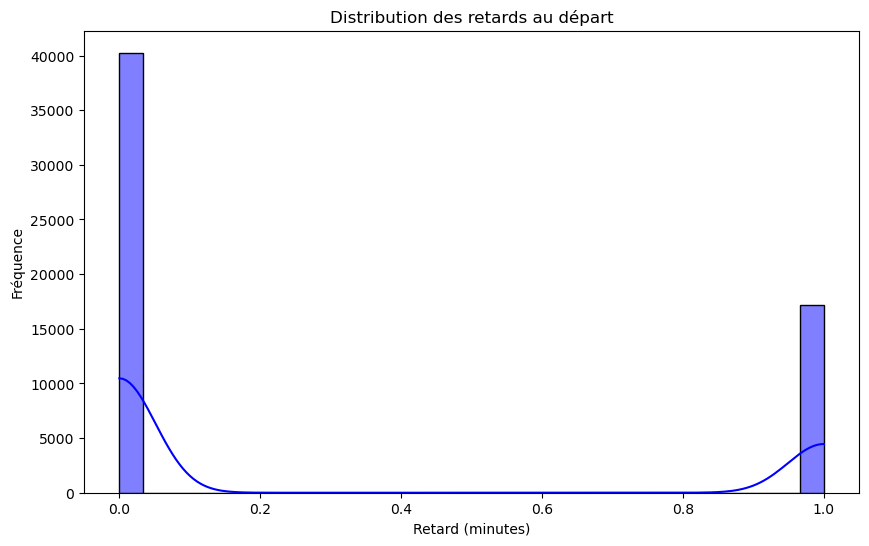

In [22]:
# Histogramme
plt.figure(figsize=(10, 6))
sns.histplot(df['Retard'], kde=True, bins=30, color='blue')
plt.title("Distribution des retards au départ")
plt.xlabel("Retard (minutes)")
plt.ylabel("Fréquence")
plt.show()


In [27]:
# Supprimer le suffixe ":00" dans la colonne si présent
df['Scheduled departure time'] = df['Scheduled departure time'].dt.time

# Nuage de points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Scheduled departure time', y='Retard', data=data, alpha=0.5)
plt.title("Relation entre l'heure de départ et le retard")
plt.xlabel("Heure de départ")
plt.ylabel("Retard (minutes)")
plt.show()


AttributeError: Can only use .dt accessor with datetimelike values